
# Stage 10b — Modeling: Time Series and Classification (Filled Submission)

**Notebook:** `notebooks/modeling_time_series_panwei.ipynb`  
**Goal:** Create lag/rolling features on a time series, then build a baseline classification model to predict next-step direction.


In [1]:

import numpy as np, pandas as pd
np.random.seed(42)


In [2]:

# 1) Generate synthetic time series of "returns" and price
import matplotlib.pyplot as plt

n = 500
dates = pd.date_range("2020-01-01", periods=n, freq="D")
eps = np.random.normal(0, 0.02, size=n)  # noise
returns = 0.001 + eps                     # small drift
prices = 100 + np.cumsum(returns)

df = pd.DataFrame({"price": prices, "ret": returns}, index=dates)
df.head()


,price,ret
2020-01-01,100.010934,0.010934
2020-01-02,100.009169,-0.001765
2020-01-03,100.023123,0.013954
2020-01-04,100.054583,0.031461
2020-01-05,100.050900,-0.003683


In [3]:

# 2) Feature engineering (lag & rolling, avoid leakage)
df["lag1"] = df["ret"].shift(1)
df["lag2"] = df["ret"].shift(2)
df["roll_mean3"] = df["ret"].rolling(3).mean()
df["roll_std5"] = df["ret"].rolling(5).std()

# Drop NaNs from rolling/lagging
df = df.dropna()
df.head()


,price,ret,lag1,lag2,roll_mean3,roll_std5
2020-01-05,100.050900,-0.003683,0.031461,0.013954,0.013910,0.014165
2020-01-06,100.047218,-0.003683,-0.003683,0.031461,0.008032,0.015423
2020-01-07,100.079802,0.032584,-0.003683,-0.003683,0.008406,0.017857
2020-01-08,100.096151,0.016349,0.032584,-0.003683,0.015083,0.017884
2020-01-09,100.087761,-0.008389,0.016349,0.032584,0.013514,0.017366


In [4]:

# 3) Next-step direction classification target
df["y_up"] = (df["ret"].shift(-1) > 0).astype(int)
df = df.dropna()
X = df[["lag1","lag2","roll_mean3","roll_std5"]]
y = df["y_up"]


In [5]:

# 4) Time-aware split: first 70% train, last 30% test
split_idx = int(len(df)*0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [6]:

# 5) Pipeline: scaling + logistic regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = Pipeline([("scaler", StandardScaler()),
                ("logreg", LogisticRegression(max_iter=1000))])
clf.fit(X_train, y_train)


,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Accuracy: 0.497, Precision: 0.505, Recall: 0.711, F1: 0.590


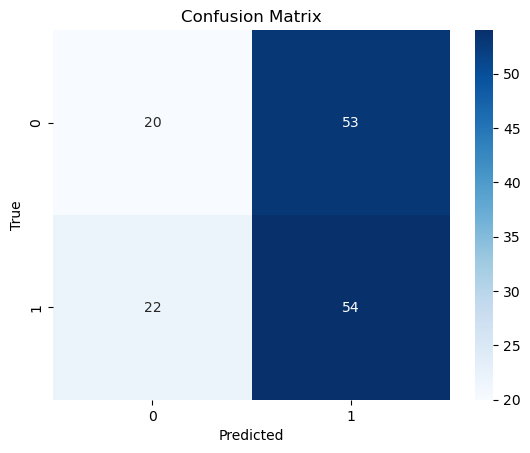

In [7]:

# 6) Metrics + confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


[Last-fold hold-out] Accuracy: 0.451  Precision: 0.438  Recall: 0.757  F1: 0.554


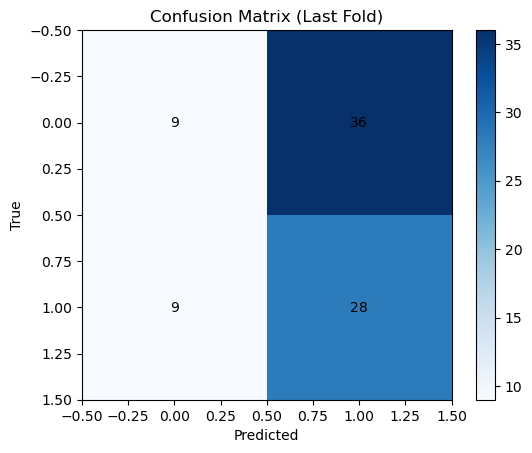

In [8]:
# --- TimeSeriesSplit: last fold as hold-out test ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Ensure chronological order (important for TSCV)
X = X.sort_index()
y = y.loc[X.index]

# Create splits
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X))[-1]  # take the final split as the test

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Pipeline (preprocessing → model)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
print(f"[Last-fold hold-out] Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")

# Confusion matrix plot (matplotlib only)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Last Fold)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.colorbar(im, ax=ax)
plt.show()


2) Cross-validated evaluation across all TimeSeriesSplit folds

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Ensure chronological order
X = X.sort_index()
y = y.loc[X.index]

tscv = TimeSeriesSplit(n_splits=5)

accs, precs, recs, f1s = [], [], [], []

for fold, (tr, te) in enumerate(tscv.split(X), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    accs.append(accuracy_score(y_te, y_hat))
    precs.append(precision_score(y_te, y_hat))
    recs.append(recall_score(y_te, y_hat))
    f1s.append(f1_score(y_te, y_hat))

    print(f"Fold {fold}: acc={accs[-1]:.3f}, prec={precs[-1]:.3f}, rec={recs[-1]:.3f}, f1={f1s[-1]:.3f}")

print("\n=== TimeSeriesSplit CV (5 folds) ===")
print(f"Accuracy  : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
print(f"F1        : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")


Fold 1: acc=0.524, prec=0.586, rec=0.386, f1=0.466
Fold 2: acc=0.488, prec=0.588, rec=0.417, f1=0.488
Fold 3: acc=0.488, prec=0.542, rec=0.565, f1=0.553
Fold 4: acc=0.524, prec=0.545, rec=0.800, f1=0.649
Fold 5: acc=0.451, prec=0.438, rec=0.757, f1=0.554

=== TimeSeriesSplit CV (5 folds) ===
Accuracy  : 0.495 ± 0.027
Precision : 0.540 ± 0.055
Recall    : 0.585 ± 0.170
F1        : 0.542 ± 0.064



## Interpretation

- **Features:** `lag1`, `lag2`, `roll_mean3`, `roll_std5` use only past values (no leakage).
- **Split:** Time-aware 70/30 split respects chronology.
- **Pipeline:** StandardScaler → LogisticRegression avoids leakage from scaling.
- **Results:** Classification scores provide a baseline; financial returns are noisy so expect modest gains over chance.
- **Risks/Assumptions:** Stationarity and linear decision boundary may not hold; consider richer features or models.



> **Rubric checklist**  
> - ✔ Feature engineering correctness (no leakage)  
> - ✔ Pipeline implementation  
> - ✔ Appropriate split strategy  
> - ✔ Metrics & plots correctness  
> - ✔ Interpretation quality  
